In [1]:


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import h5py
import pickle
import warnings
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from sklearn.random_projection import GaussianRandomProjection
from scipy import stats
from scipy.stats import zscore, norm, spearmanr
import pingouin
from scipy.optimize import curve_fit
import sympy as sp
from sklearn.model_selection import GroupKFold, StratifiedKFold, RepeatedKFold,LeavePGroupsOut, GroupShuffleSplit
from joblib import Parallel, delayed

warnings.filterwarnings('ignore')

def save(x, filename):
    pickle.dump(x, open(f'{filename}.pkl', 'wb'))
def load(filename):
    pd.read_pickle(filename)



lb = ['bear', 'elephant', 'person', 'car', 'dog', 'apple', 'chair', 'plane', 'bird', 'zebra']
labels = np.repeat(lb, 60, axis=0)


NB_CONTEXT_TYPES = 10
NB_OBJECT_TYPES = 10
NB_IMAGES = 600
seeds=[0, 6, 28, 42, 77, 94, 127, 255, 546, 612]


beh_sig_sbj=pd.read_pickle('results/behavioral_signatures_primates.pkl')
self_consistency= pd.read_pickle('results/self-consistency.pkl')
self_consistency.keys()


dict_keys(['primates', 'humans', 'Bento', 'Magneto', 'pooled monkeys', 'mean monkeys'])

In [2]:


def get_splithalf_corr(data, num_seeds=10, decode_=False, nb_trials_subsample=None, img_subsample=list(range(600))):
    # Calculate split-half correlation for 100 seeds
    num_neurons=data.shape[2]
    print(f'number of neurons {num_neurons}, number of images: {data.shape[0]}, number of trials: {data.shape[1]}')
    split_half_correlation = { 'I1': np.zeros((num_seeds,num_neurons)),
                               'C1': np.zeros((num_seeds,num_neurons)),
                             'I1_decode': np.zeros((num_seeds,num_neurons)),
                             'C1_decode': np.zeros((num_seeds,num_neurons))}
    nb_trials = data.shape[1]
    subsample_trials=data.shape[1]//2 if nb_trials_subsample==None else nb_trials_subsample//2
    splits=iter(np.array([
    [
        np.random.seed(seed), 
        np.random.permutation(nb_trials)[0:subsample_trials],
        np.random.seed(seed),
        np.random.permutation(nb_trials)[subsample_trials:2*subsample_trials]
    ][1::2] for seed in range(num_seeds)]).reshape((num_seeds*2, subsample_trials)) )
    for i in range(num_seeds):
        
        sh1, sh2 = data[:,next(splits)].mean(axis=1), data[:,next(splits)].mean(axis=1)
        
        i1_corr_values = [ spearmanr(sh1[:,  j], sh2[:, j])[0] for j in range(num_neurons)]
        
        i1_shc=np.array(i1_corr_values)
        i1_shc=(2*i1_shc)/(1+i1_shc)
        split_half_correlation['I1'][i] = i1_shc
        if decode_:
            _,p_sh1= decode(sh1.T, labels,nrfolds=5, seed=i )
            _,p_sh2= decode(sh2.T, labels,nrfolds=5, seed=i )
            pc_sh1=get_percent_correct_from_proba(p_sh1,labels)
            pc_sh2=get_percent_correct_from_proba(p_sh2,labels)
            print(pc_sh1.shape,  pc_sh2.shape)
            i1_pred_shc = np.corrcoef(np.nanmean(pc_sh1, axis=1)[img_subsample], np.nanmean(pc_sh2, axis=1)[img_subsample])[0,1]
            #print(i1_pred_shc)
            i1_pred_shc = (2*i1_pred_shc)/(1+i1_pred_shc)
            c1_pred_shc = np.corrcoef([np.nanmean(pc_sh1, axis=1)[k::NB_CONTEXT_TYPES].mean(axis=0) for k in range(NB_CONTEXT_TYPES)],
                                      [np.nanmean(pc_sh2, axis=1)[k::NB_CONTEXT_TYPES].mean(axis=0) for k in range(NB_CONTEXT_TYPES)])[0,1]

            c1_pred_shc = (2*c1_pred_shc)/(1+c1_pred_shc)
            split_half_correlation['I1_decode'][i] = i1_pred_shc
            split_half_correlation['C1_decode'][i] = c1_pred_shc
        c1_sh1 = np.array([sh1[k::NB_CONTEXT_TYPES].mean(axis=0) for k in range(NB_CONTEXT_TYPES)])
        c1_sh2 = np.array([sh2[k::NB_CONTEXT_TYPES].mean(axis=0) for k in range(NB_CONTEXT_TYPES)])
        c1_corr_values = [ spearmanr(c1_sh1[:, j], c1_sh2[:, j])[0] for j in range(num_neurons)]
        
        c1_shc=np.array(c1_corr_values)
        c1_shc=(2*c1_shc)/(1+c1_shc)
        split_half_correlation['C1'][i] = c1_shc 
        

    print(f"Average split-half correlation across {num_seeds} seeds I1: {np.nanmean(split_half_correlation['I1']):.4f} C1: {np.nanmean(split_half_correlation['C1']):.4f}")
    return split_half_correlation 

In [3]:
pooled_rates_full=pd.read_pickle('../neural_data/pooled_rates_both.pkl')
print('pooled rates images x trials x bins x neurons', pooled_rates_full.shape)

pooled_rates_7_17=np.nanmean(pooled_rates_full[:,:,7:17,:], axis=2)
print('pooled rates 70-170 ms images x trials  x neurons', pooled_rates_7_17.shape)
pooled_rates_10_18=np.nanmean(pooled_rates_full[:,:,10:18,:], axis=2)


# Getting the most reliable rates based on 70-170 ms
shc= get_splithalf_corr(pooled_rates_7_17[:,:-1,:], num_seeds=100)

df_shc=pd.DataFrame(shc['I1'].T.mean(axis=1), columns=['I1'])
df_shc['C1']=shc['C1'].T.mean(axis=1)

pooled rates images x trials x bins x neurons (600, 31, 30, 222)
pooled rates 70-170 ms images x trials  x neurons (600, 31, 222)
number of neurons 222, number of images: 600, number of trials: 30
Average split-half correlation across 100 seeds I1: 0.2743 C1: 0.5355


In [4]:
reliable_rates=df_shc[df_shc['I1']>0.1].index
reliable_neurons_7_17=pooled_rates_7_17[:,:-1,reliable_rates]
reliable_neurons_10_18=pooled_rates_10_18[:,:-1,reliable_rates]
print('reliable pooled rates 70-170 ms images x trials  x neurons', reliable_neurons_7_17.shape)
print('reliable pooled rates 100-180 ms images x trials  x neurons', reliable_neurons_10_18.shape)

reliable pooled rates 70-170 ms images x trials  x neurons (600, 30, 122)
reliable pooled rates 100-180 ms images x trials  x neurons (600, 30, 122)


In [8]:
from decode_utils import get_percent_correct_from_proba
def decode(features,labels,nrfolds=2,seed=0):

    
    classes=np.unique(labels)
    nrImages = features.shape[1]
    _,ind = np.unique(classes, return_inverse=True)   
    
    num_classes = len(classes)
    prob = np.zeros((nrImages,len(classes)))
    prob[:]=np.NAN
    actual_pred=np.zeros(nrImages)
    all_pred = np.zeros(nrImages)
    all_pred[:]=np.NAN
    actual_pred[:]=np.NAN
    
    #kf=KFold(nrfolds,shuffle=True, random_state=seed)
    kf=GroupKFold(n_splits=nrfolds )

    np.random.seed(seed)
    groups = np.repeat(np.random.permutation(np.arange(NB_IMAGES/NB_CONTEXT_TYPES)),NB_CONTEXT_TYPES )
    np.random.seed(seed)
    for train, test in kf.split(features.T, groups=groups):
        #print(train, test)
        XTrain = features[:,train]
        #print(XTrain.shape, seed)
        XTest = features[:,test]
        YTrain = labels[train]
        YTest = labels[test]
        clf = make_pipeline(StandardScaler(),SVC(C=5*10e4, max_iter=-1, probability=True)).fit(XTrain.T, YTrain)
        pred=clf.predict_proba(XTest.T)
        prob[test,0:num_classes]=pred
    return actual_pred, prob



In [9]:
shc={}
for i in range(2,pooled_rates_7_17[:,:-1,reliable_rates].shape[1]+1,2):
    shc[i]= get_splithalf_corr(pooled_rates_7_17[:,:-1,reliable_rates], num_seeds=10, decode_=True, 
                              nb_trials_subsample=i)

#save(shc, 'shc_7_17_all_trials')

number of neurons 122, number of images: 600, number of trials: 30
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
Average split-half correlation across 10 seeds I1: 0.1690 C1: 0.0196
number of neurons 122, number of images: 600, number of trials: 30
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
Average split-half correlation across 10 seeds I1: 0.2170 C1: 0.1268
number of neurons 122, number of images: 600, number of trials: 30
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
Average split-half correlation across 10 seeds I1: 0.2433 C1:

KeyboardInterrupt: 

In [ ]:
shc={}
for i in range(10):
    images_context=list(range(i,600,10))
    shc[i]= get_splithalf_corr(pooled_rates_7_17[:,:-1,reliable_rates], num_seeds=10, decode_=True, 
                           img_subsample= images_context)

#save(shc, 'shc_7_17_all_context')

In [ ]:
list(reliable_rates)

In [10]:
def decode_one_trial(features, nrfolds):
    acc_all=[]
    for j in range(10):
        acc,p = decode(features, labels, nrfolds=nrfolds, seed=j)
        pc=get_percent_correct_from_proba(p,labels)
        acc_all.append(np.nanmean(pc, axis=1))
    return np.array(acc_all).mean(axis=0), acc_all

def process_one_bin(start, length):
    trials = pooled_rates_full[:, :30, start:start + length, reliable_rates].mean(axis=2)
    neural_trial_splits=subsample_trials(trials, list(range(1,31)))
    tasks=[(num_trials, i) for num_trials in neural_trial_splits.keys() for i in range(1  if num_trials==list(neural_trial_splits.keys())[-1] else 10)]
    print(len(tasks))
    results = Parallel(n_jobs=-1, verbose=10)(delayed(decode_one_trial)(neural_trial_splits[num_trials][i].mean(axis=1).T, nrfolds=5) for (num_trials, i) in tasks)
    acc_mean_dic, acc_full_dic={},{}
    for idx,  result in enumerate(results):
        num_trials, i=tasks[idx]
        if num_trials not in acc_mean_dic.keys():
            acc_mean_dic[num_trials]=[] 
            acc_full_dic[num_trials]=[] 
        acc_mean_dic[num_trials].append(result[0])
        acc_full_dic[num_trials].append(result[1])
    return acc_mean_dic, acc_full_dic


def subsample_trials(trials, num_trials_increase):
    all_trials=dict()
    list_index= list(range(trials.shape[1]))
    num_trials=trials.shape[1]
    for nb_trials_to_take in num_trials_increase:
        
        all_trials_seed=[]
        for shuffle_seed in seeds:
            unq_seed=hash((nb_trials_to_take, shuffle_seed)) & ((1 << 32) - 1)
            np.random.seed(unq_seed)
            shuffled_list=np.random.permutation(list_index)
            all_trials_seed.append(trials[:,shuffled_list[:nb_trials_to_take]])
        all_trials[nb_trials_to_take] = np.array(all_trials_seed)
    return all_trials

In [11]:
from joblib import Parallel, delayed
import numpy as np
all_neurons=122
acc_diff_rates_all=dict()
# Define a function to handle the processing for each num_neurons
def process_num_neurons(num_neurons, reliable_neurons):
    acc_diff_rates = {}
    std_acc_diff_rates = {}
    
    list_neuron_idxs = list(range(all_neurons))
    nb_seeds=10 if num_neurons < 121 else 1
    for shuffle_seed in range(10):
        unq_seed=hash((num_neurons, shuffle_seed)) & ((1 << 32) - 1)
        acc_diff_rates[shuffle_seed], std_acc_diff_rates[shuffle_seed] = {}, {}
        np.random.seed(unq_seed)
        list_neuron_idxs = np.random.permutation(list_neuron_idxs)
        
        trials = reliable_neurons[:, :,list_neuron_idxs[:num_neurons]]
        neural_trial_splits=subsample_trials(trials, list(range(1,31,2)))
        for num_trials in neural_trial_splits.keys():
            acc_diff_rates[shuffle_seed][num_trials], std_acc_diff_rates[shuffle_seed][num_trials]=[],[]
            i_seeds=1 if num_trials==list(neural_trial_splits.keys())[-1] else 10
            for i in range(i_seeds):
                features=neural_trial_splits[num_trials][i].mean(axis=1).T
                acc_all=[]
                for j in range(5):
                    acc,p = decode(features, labels, nrfolds=5, seed=j)
                    pc=get_percent_correct_from_proba(p,labels)
                    acc_all.append(np.nanmean(pc, axis=1))
            
                acc_diff_rates[shuffle_seed][num_trials].append(np.array(acc_all).mean(axis=0))
                std_acc_diff_rates[shuffle_seed][num_trials].append(acc_all)
    # long processing per neurons subsample, so we save the accuracy result each time we increase the N neurons taken
    save(acc_diff_rates, f'results/no_dd/acc_increase_7_17/{num_neurons}')


acc_diff_rates = {}
std_acc_diff_rates = {}
num_ns = 123
start, end = 7, 17
Parallel(n_jobs=-1,  verbose=20)(
    delayed(process_num_neurons)(num_neurons, reliable_neurons_7_17)
    for num_neurons in range(5, num_ns,1)
)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  

KeyboardInterrupt: 

# Skip running this cell if you didn't run the above fully

In [7]:
import os
files=os.listdir('results/no_dd/acc_increase_7_17/')
acc_all_neurons=dict()
for file in files:
    nb_neurons=int(file.removesuffix('.pkl'))
    acc = pd.read_pickle('results/no_dd/acc_increase_7_17/'+file)
    acc_all_neurons[nb_neurons]=acc

#save(acc_all_neurons, 'results/acc_600_decoding_5f_7-17_increase')

In [15]:
def get_beh_signatures_from_acc(acc):
    
    I1_neural = acc
    C1_neural = [np.mean(I1_neural[i::NB_CONTEXT_TYPES]) for i in range(NB_CONTEXT_TYPES)]
    C1_extended_neural = [C1_neural[i % NB_CONTEXT_TYPES] for i in range(NB_IMAGES)]
    I1n_neural = np.array(I1_neural)-np.array(C1_extended_neural)
    return {'I1': I1_neural,
                           'C1': np.array(C1_neural),
                           'I1n': I1n_neural
    }

def sigmoid(x, a1, b1, c1, d):
        sigmoid1 = a1 / (1 + np.exp(-(x - b1)/c1))
        return sigmoid1+d
    
def log_funct(x, a, b):
    return a * np.log(x) + b

def get_pcorr_extrapolation(x_data, y_data, std_data,plot, title,funct=sigmoid, start=1, end=100, log_scale=False, remove_thresh=0.001):
    #np.random.seed(0)
    #y_data=np.round(y_data,2)
    params, covariance = curve_fit(funct, x_data, y_data,maxfev = 5000000)
    loss = np.sum((y_data - funct(x_data, *params)) ** 2)
    print('loss',loss)
    if plot:
 
        x_extrapolated = np.linspace(start, end, 100)  # Adjust the range as needed
        y_extrapolated = funct(x_extrapolated, *params)

        plt.scatter(x_data, y_data, label='Original Data')
        plt.plot(x_extrapolated, y_extrapolated, label='Extrapolation', linestyle='--', color='red')
        plt.errorbar(x_data,y_data, yerr=std_data, alpha=0.5, c='gray', fmt='.')
        if log_scale:
            plt.xscale('log')
        plt.legend()
        plt.xlabel('number of existing trials taken')
        plt.ylabel('% EV explained by neurons')
        sns.despine()
        plt.title(title)
        plt.show()
    if loss>remove_thresh:
        return np.nan, loss

    x, a, b,c,d = sp.symbols('x a b c d')
    # Define the functions
    sigmoid = a / (1 + sp.exp(-(x - b))/c) +d
    log = a * sp.log(x) + b
    # Substitute specific parameter values
    if funct ==  log_funct:
        print('using log')
        a_v, b_v= params 
        funct_with_values = log.subs({a: a_v, b: b_v})
    else:
        print('using sigmoid')
        a_v, b_v,c_v,d_v = params 
        funct_with_values = sigmoid.subs({a: a_v, b: b_v,c:c_v,d:d_v})
    # Substitute values into the sigmoid expression
    # Calculate the limit as x approaches positive infinity
    limit_at_infinity_specific = sp.limit(funct_with_values, x, sp.oo)

    return float(limit_at_infinity_specific), loss
def get_pcorr_limit_neurons(acc_neurons_subsb, title, idx=None, plot=False, remove_thresh=0.001): #acc_neurons_subsb for nb neurons seed
    import pingouin
    neural_trials=acc_neurons_subsb#np.array([acc_neurons_subsb[key] for key in acc_neurons_subsb.keys()])
    x,y ='humans', 'monkeys'
    df_human_monkey=pd.DataFrame(beh_sig_sbj[signature])[[x,y]].iloc[idx]
    pcorr, esv=dict(), {}
    for i_trials in acc_neurons_subsb.keys():
        pcorr[i_trials], esv[i_trials]=[],[]
        i_seeds=10# if i_trials==9 else 10
        for i_seed in range(len(acc_neurons_subsb[i_trials])):
            #df_human_monkey=pd.DataFrame(get_beh_signatures_from_acc(all_trials[x][i_trials][i_seed])[signature], columns=[x])
            #df_human_monkey[y]=get_beh_signatures_from_acc(all_trials[y][i_trials][i_seed])[signature]
            df_model=pd.DataFrame(get_beh_signatures_from_acc(neural_trials[i_trials][i_seed])[signature])
            partial_correlation = pd.concat((df_human_monkey, df_model), axis=1).iloc[idx].pcorr()[x][y]
            pcorr[i_trials].append(partial_correlation)
            correlation_hm=df_human_monkey.corr()[x][y]#/(self_consistency[x][signature][0]*self_consistency[y][signature][0])
            esv[i_trials].append(((correlation_hm**2-partial_correlation**2)/(correlation_hm**2))*100)
            #if i_trials==9:
            #    print(signature, pcorr[i_trials])
    var_to_plot=pcorr
    limit, loss = get_pcorr_extrapolation(log_scale=False,
                                          x_data = list(range(1,31,2)),
                                          y_data = np.array([np.median(var_to_plot[i_trials]) for i_trials in var_to_plot.keys()]), title=title,std_data= np.array([np.nanstd(var_to_plot[i_trials]) for i_trials in var_to_plot.keys()]), plot=plot, remove_thresh=remove_thresh )
    limit_r = np.nan if limit >=0.9 else limit
    return limit_r, loss 



In [16]:
import pandas as pd
from joblib import Parallel, delayed

signature='C1'
remove_thresh=0.001 if signature=='I1' else 0.05


acc_diff_rates=pd.read_pickle('results/acc_600_decoding_5f_7-17_increase.pkl')

limits, losses = dict(), dict()


# Set the number of cores to use

results = Parallel(n_jobs=-1, verbose=10)(delayed(get_pcorr_limit_neurons)(acc_diff_rates[nb_neurons][seed], remove_thresh=remove_thresh,title='',idx=list(range(600 if signature=='I1' else 10))) for nb_neurons in list(acc_diff_rates.keys()) for seed in range(10))





[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_3932/261668623.py:13: RuntimeWarning: overflow encountered in exp
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable

/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    3.6s
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_3932/261668623.py:13: RuntimeWarning: overflow encountered in exp
/var/folders/mz/npqk0_xx6n106m20__gg

/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
[Parallel(n_jobs=-1)]: Done 161 tasks      | elapsed:    6.7s
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_3932/261668623.py:13: RuntimeWarning: overflow encountered in exp
/Users/Sara/.pyenv/versions/3.10.4/e

/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the 

/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
[Parallel(n_jobs=-1)]: Done 372 tasks      | elapsed:   13.2s
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the paramet

/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_3932/261668623.py:13: RuntimeWarning: overflow encountered in exp
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize

/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_3932/261668623.py:13: RuntimeWarning: overflow encountered in exp
/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_3932/261668623.py:13: RuntimeWarning: overflow encountered in exp
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameter

/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_3932/261668623.py:13: RuntimeWarning: overflow encountered in exp
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize

/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_3932/261668623.py:13: RuntimeWarning: overflow encountered in exp
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize

/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_3932/261668623.py:13: RuntimeWarning: overflow encountered in exp
/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_3932/261668623.py:13: RuntimeWarning: overflow encountered in exp
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameter

[Parallel(n_jobs=-1)]: Done 993 tasks      | elapsed:   31.6s
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the paramet

In [17]:
tasks = [(nb_neurons, seed) for nb_neurons in list(acc_diff_rates.keys()) for seed in range(10)]
limits, losses = dict(), dict()
for result, key in zip(results,tasks):
    limit, loss = result
    num_neurons, shuffle_seed=key[0], key[1]
    if num_neurons not in limits:
        limits[num_neurons],losses[num_neurons] =[],[]
    limits[num_neurons].append(np.nanmean(limit))
    losses[num_neurons].append(np.nanmean(loss))
    
    
#save_str=f'{signature}_increasing_neurons_7-17_subsampling'
#save(limits, f'results/pcor_{save_str}')
#save(losses, f'results/loss_{save_str}')







In [18]:
import pandas as pd
from joblib import Parallel, delayed
def get_corr_sbj(neural_data, signature):
    x,y='humans', 'monkeys'
    beh_sig_sbj=pd.read_pickle('results/behavioral_signatures_primates.pkl')
    mh_df = pd.DataFrame(beh_sig_sbj[signature])[[x,y]]
    corr_h, corr_m=[],[]
    for i in neural_data.keys():
        neural_signature=pd.DataFrame(get_beh_signatures_from_acc(neural_data[i])[signature])
        corr_h.append(pd.concat((neural_signature,mh_df
                                ), axis=1).corr()[x][0])
        corr_m.append(pd.concat((neural_signature,  mh_df), axis=1).corr()[y][0])
    return corr_h, corr_m
signature='C1'
remove_thresh=0.001 if signature=='I1' else 0.05


acc_diff_rates=pd.read_pickle('results/no_dd/acc_600_decoding_5f_122neurons_increase_n_7-10_pc_no_dd.pkl')

limits, losses = dict(), dict()


# Set the number of cores to use

results = Parallel(n_jobs=-1, verbose=10)(delayed(get_corr_sbj)(acc_diff_rates[nb_neurons], signature) for nb_neurons in acc_diff_rates.keys())

tasks = [nb_neurons for nb_neurons in acc_diff_rates.keys()]
corr_h, corr_m = dict(), dict()
for result, key in zip(results,tasks):
    corr_h[key]= result[0]
    corr_m[key]=result[1]
    
    
    
#save_str=f'{signature}_increasing_neurons_7-17_subsampling'
#save(corr_h, f'results/corr_humans_{save_str}')
#save(corr_m, f'results/corr_monkeys_{save_str}')




FileNotFoundError: [Errno 2] No such file or directory: 'results/no_dd/acc_600_decoding_5f_122neurons_increase_n_7-10_pc_no_dd.pkl'

loss 0.07303908189557046
loss 0.020863281804490826
using sigmoid
loss 0.023944127599009716
using sigmoid
loss 0.0034352907479528513
using sigmoid
loss 0.07100160402022841
loss 0.14973611590509253
loss 0.03298519979299235
using sigmoid
loss 0.03629507194101423
using sigmoid
loss 0.01842285010908816
using sigmoid
loss 0.012786968098497721
using sigmoid
loss 0.03661739031478758
using sigmoid
loss 0.013606941329294141
using sigmoid
loss 0.007736000626449445
using sigmoid
loss 0.009282655994486445
using sigmoid
loss 0.017347941549511803
using sigmoid
loss 0.005287557749148947
using sigmoid
loss 0.015349677719766183
using sigmoid
loss 0.04520915628775815
using sigmoid
loss 0.007454054841771548
using sigmoid
loss 0.02614650135047033
using sigmoid
loss 0.023298158499976983
using sigmoid
loss 0.021424757787633773
using sigmoid
loss 0.030308766906723968
using sigmoid
loss 0.021940184047609997
using sigmoid
loss 0.008210007701245055
using sigmoid
loss 0.01887109414149997
using sigmoid
loss 0.0530

loss 0.012350569938518456
using sigmoid
loss 0.018705183794501805
using sigmoid
loss 0.019841307144208828
using sigmoid
loss 0.019882362595212536
using sigmoid
loss 0.008630530064573412
using sigmoid
loss 0.019767108958538972
using sigmoid
loss 0.02231079983310101
using sigmoid
loss 0.023830931646900633
using sigmoid
loss 0.011189549945880515
using sigmoid
loss 0.01224873612053971
using sigmoid
loss 0.03803114589034004
using sigmoid
loss 0.01868648275535886
using sigmoid
loss 0.016057255564160964
using sigmoid
loss 0.017033274432895616
using sigmoid
loss 0.040251308625406754
using sigmoid
loss 0.03480784803672418
using sigmoid
loss 0.022053775223335396
using sigmoid
loss 0.020554845661348176
using sigmoid
loss 0.009628451572393771
using sigmoid
loss 0.011053692553220099
using sigmoid
loss 0.009697427530039219
using sigmoid
loss 0.03780714640562724
using sigmoid
loss 0.02229143444058762
using sigmoid
loss 0.022415791096786195
using sigmoid
loss 0.012204168062650466
using sigmoid
loss 0.

loss 0.01437404927429123
using sigmoid
loss 0.031232562014938063
using sigmoid
loss 0.02135646982110416
using sigmoid
loss 0.03742836234550766
using sigmoid
loss 0.012478133657576614
using sigmoid
loss 0.02229510584601652
using sigmoid
loss 0.008483034237809552
using sigmoid
loss 0.007763686690477083
using sigmoid
loss 0.050315801272893444
loss 0.007266496649631314
using sigmoid
loss 0.02920609818822417
using sigmoid
loss 0.019257207493828716
using sigmoid
loss 0.009009409782436768
using sigmoid
loss 0.03358121927278955
using sigmoid
loss 0.010907777227878904
using sigmoid
loss 0.032497963141121355
using sigmoid
loss 0.00684414434655005
using sigmoid
loss 0.05600636168852957
loss 0.016786501189732437
using sigmoid
loss 0.010483632532670912
using sigmoid
loss 0.00525412378923281
using sigmoid
loss 0.04041779114077241
using sigmoid
loss 0.01186655313086015
using sigmoid
loss 0.0086045505024462
using sigmoid
loss 0.028822378193617305
using sigmoid
loss 0.014919183631240465
using sigmoid
l

loss 0.016857821228529107
using sigmoid
loss 0.0068404864080358506
using sigmoid
loss 0.023264707739904716
using sigmoid
loss 0.01999494713013919
using sigmoid
loss 0.018978915587350053
using sigmoid
loss 0.00811622221912917
using sigmoid
loss 0.02220628645480871
using sigmoid
loss 0.01294393933631282
using sigmoid
loss 0.04069078792456737
using sigmoid
loss 0.033232487053168454
using sigmoid
loss 0.010292745922916808
using sigmoid
loss 0.011120293626842472
using sigmoid
loss 0.04059165328039506
using sigmoid
loss 0.014575257877738132
using sigmoid
loss 0.020148664622528817
using sigmoid
loss 0.007332714441040128
using sigmoid
loss 0.05914385258091607
loss 0.02950880246038793
using sigmoid
loss 0.017156448937812534
using sigmoid
loss 0.007392940507101227
using sigmoid
loss 0.012241439381283532
using sigmoid
loss 0.0074446724986432415
using sigmoid
loss 0.02193819900438492
using sigmoid
loss 0.12587909467185912
loss 0.008231876068117532
using sigmoid
loss 0.09867160568630726
loss 0.0128

In [28]:
x,y='humans', 'pooled monkeys'

limits_c1=pd.read_pickle('results/pcor_C1_increasing_neurons_7-17_subsampling.pkl')
limits_i1=pd.read_pickle('results/pcor_I1_increasing_neurons_7-17_subsampling.pkl')

losses_i1=pd.read_pickle('results/loss_I1_increasing_neurons_7-17_subsampling.pkl')
losses_c1=pd.read_pickle('results/loss_C1_increasing_neurons_7-17_subsampling.pkl')
corr_h_c1=pd.read_pickle('results/corr_humans_C1_increasing_neurons_7-17_subsampling.pkl')
corr_h_i1=pd.read_pickle('results/corr_humans_I1_increasing_neurons_7-17_subsampling.pkl')
corr_m_i1=pd.read_pickle('results/corr_monkeys_I1_increasing_neurons_7-17_subsampling.pkl')
corr_m_c1=pd.read_pickle('results/corr_monkeys_C1_increasing_neurons_7-17_subsampling.pkl')




self_consistency=pd.read_pickle('results/self-consistency.pkl')
beh_sig_sbj=pd.read_pickle('results/behavioral_signatures_primates.pkl')
esv = dict()
std=dict()
mh_df_i1 = pd.DataFrame(beh_sig_sbj['I1'])[[x,y]]
mh_df_c1 = pd.DataFrame(beh_sig_sbj['C1'])[[x,y]]

corr_i1 = mh_df_i1.corr()[x][y]#/(self_consistency['humans']['I1'][0]*self_consistency['pooled monkeys']['I1'][0])
corr_c1 = mh_df_c1.corr()[x][y]#/(self_consistency['humans']['C1'][0]*self_consistency['pooled monkeys']['C1'][0])

all_info={'esv I1':{'mean':{}, 'std':{}},
        'pcor I1':{'mean':{}, 'std':{}},
          'corr h I1':{'mean':{}, 'std':{}},
          'corr h C1':{'mean':{}, 'std':{}},
          'corr m I1':{'mean':{}, 'std':{}},
          'corr m C1':{'mean':{}, 'std':{}},
          'loss I1':{'mean':{}, 'std':{}},
          'loss C1':{'mean':{}, 'std':{}},
        'esv C1':{'mean':{}, 'std':{}},
        'pcor C1':{'mean':{}, 'std':{}},
        'loss':{'mean':{}, 'std':{}},
         }

for nb_neurons in limits_i1.keys():
    all_info['corr h I1']['mean'][nb_neurons]= np.nanmean(corr_h_i1[nb_neurons])
    all_info['corr h I1']['std'][nb_neurons]= np.nanstd(corr_h_i1[nb_neurons])
    all_info['corr h C1']['mean'][nb_neurons]= np.nanmean(corr_h_c1[nb_neurons])
    all_info['corr h C1']['std'][nb_neurons]= np.nanstd(corr_h_c1[nb_neurons])
    all_info['corr m I1']['mean'][nb_neurons]= np.nanmean(corr_m_i1[nb_neurons])
    all_info['corr m I1']['std'][nb_neurons]= np.nanstd(corr_m_i1[nb_neurons])
    all_info['corr m C1']['mean'][nb_neurons]= np.nanmean(corr_m_c1[nb_neurons])
    all_info['corr m C1']['std'][nb_neurons]= np.nanstd(corr_m_c1[nb_neurons])
    all_info['pcor I1']['mean'][nb_neurons]= np.nanmean(limits_i1[nb_neurons])
    all_info['pcor I1']['std'][nb_neurons]= np.nanstd(limits_i1[nb_neurons])
    all_info['loss I1']['mean'][nb_neurons]= np.nanmean(losses_i1[nb_neurons])
    all_info['loss I1']['std'][nb_neurons]= np.nanstd(losses_i1[nb_neurons])
    all_info['loss C1']['mean'][nb_neurons]= np.nanmean(losses_c1[nb_neurons])
    all_info['loss C1']['std'][nb_neurons]= np.nanstd(losses_c1[nb_neurons])

    all_info['pcor C1']['mean'][nb_neurons]= np.nanmean(limits_c1[nb_neurons])
    all_info['pcor C1']['std'][nb_neurons]= np.nanstd(limits_c1[nb_neurons])


    df= pd.DataFrame(limits_i1[nb_neurons])
    all_seeds_esv=(1-(df**2/corr_i1**2))*100
    all_info['esv I1']['std'][nb_neurons]=all_seeds_esv.std()[0]
    all_info['esv I1']['mean'][nb_neurons]=all_seeds_esv.mean()[0]
    
    df= pd.DataFrame(limits_c1[nb_neurons])
    all_seeds_esv=(1-(df**2/corr_c1**2))*100
    all_info['esv C1']['std'][nb_neurons]=all_seeds_esv.std()[0]
    all_info['esv C1']['mean'][nb_neurons]=all_seeds_esv.mean()[0]


#save(all_info, 'results/all_info_increasing_n_7-17')

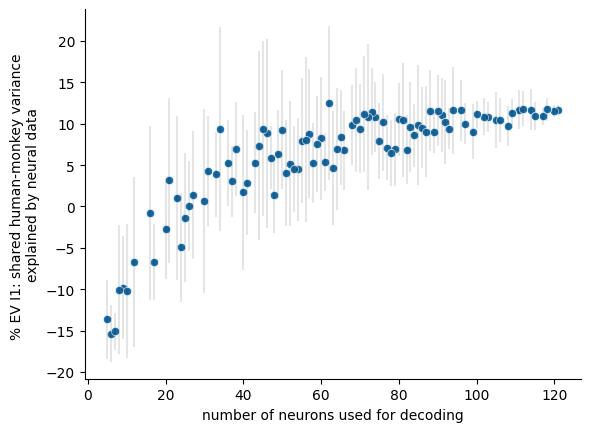

In [40]:
#all_info =pd.read_pickle('results/all_info_increasing_n_7-17.pkl')
signature='I1'
param=f'esv {signature}'
df = pd.DataFrame(all_info[param])
threshold=15 if signature=='I1' else 30 
df = df[df['std']<threshold] #remove points with high standard deviation
df=df.reset_index()
df=df[df['index']>0]
sns.scatterplot(data=df, x='index', y='mean')
plt.errorbar(x=df['index'], y=df['mean'], yerr=df['std'], fmt='.',alpha=0.1, c='k')
plt.xlabel('number of neurons used for decoding')
title= 'corrected partial correlation (limit)' if param=='limit' else 'fitting extrapolation loss' if param=='loss' else f'% EV {signature}: shared human-monkey variance \nexplained by neural data'
plt.ylabel(title)
sns.despine()
#plt.xscale('log')
plt.show()


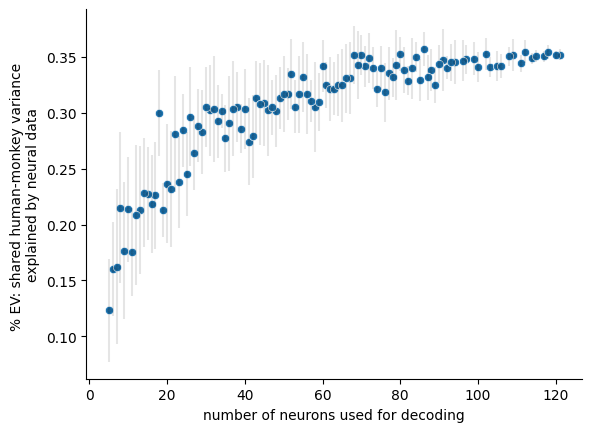

In [33]:

#all_info =pd.read_pickle('results/all_info_sigmoid_extrapolation.pkl')
signature='I1'
param=f'corr m {signature}'#f'esv {signature}'
df = pd.DataFrame(all_info[param])
df = df[df['std']<10]
df=df.reset_index()
df=df[df['index']>0]
sns.scatterplot(data=df, x='index', y='mean')
plt.errorbar(x=df['index'], y=df['mean'], yerr=df['std'], fmt='.',alpha=0.1, c='k')
plt.xlabel('number of neurons used for decoding')
title= 'corrected partial correlation (limit)' if param=='limit' else 'fitting extrapolation loss' if param=='loss' else '% EV: shared human-monkey variance \nexplained by neural data'
plt.ylabel(title)
sns.despine()
#plt.xscale('log')
plt.show()
#get_pcorr_extrapolation(x_data=np.array(list(df.index)), y_data=np.array(list(df['mean'].values)),std_data=np.array(list(df['std'].values)), plot=True, funct=mix_sigmoid, start= 0,log_scale=False)
#df['std'].plot()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


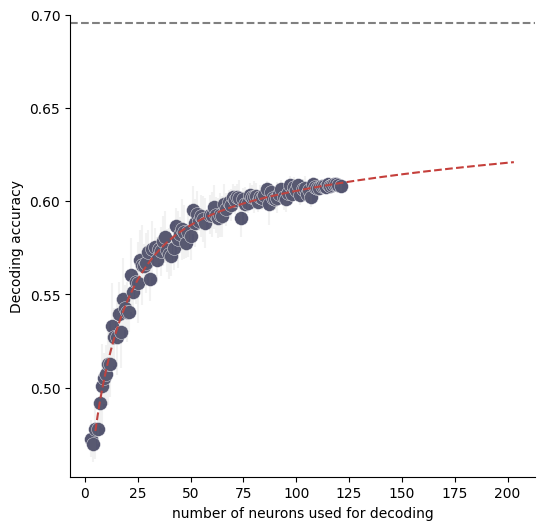

In [42]:
from scipy.optimize import curve_fit
param='mean accuracy'
acc_diff_rates=pd.read_pickle('results/no_dd/acc_600_decoding_5f_122neurons_increase_n_7-10_pc_no_dd.pkl')
acc_increase_neurons = pd.DataFrame(acc_diff_rates).applymap(lambda x: np.mean(x))#.applymap(lambda x: np.mean(x[30][1]))
acc_increase_neurons=acc_increase_neurons.drop(columns=[58])
x_data = np.array(list(acc_increase_neurons.mean().index))##np.array(list(mean_cons.keys()))#np.linspace(-10, 10, 100)
y_data =np.array(list(acc_increase_neurons.mean().values))# 5 / (1 + np.exp(-(x_data - 2)/1)) + 2 / (1 + np.exp((x_data + 4)/1.5)) + np.random.normal(0, 0.2, len(x_data))
std_data=np.array(list(acc_increase_neurons.std().values))
monkey_acc=pd.read_pickle('results/behavioral_signatures_primates.pkl')['I1']['pooled monkeys'].mean()


# Define the function with two sigmoid components
def mix_sigmoid(x, a1, b1, c1, a2, b2, c2, a3, b3, c3, a,b,d):
    sigmoid1 = a1 / (1 + np.exp(-(x - b1)/c1))
    sigmoid2 = a2 / (1 + np.exp(-(x - b2)/c2))
    sigmoid3 = a3 / (1 + np.exp(-(x - b3)/c3))
    #return a3*sigmoid1*sigmoid2+a*x**b
    #return a3*sigmoid1+a*np.sqrt(x)**b
    return sigmoid1+sigmoid2+a3*np.log(b*np.abs(x)+d)
    #return a3*np.log(b*np.abs(x)+d)
    #return  sigmoid3**2*sigmoid2*sigmoid1**8+ sigmoid1+a * x**b
    #return np.log(sigmoid1)*sigmoid2**2+np.log(sigmoid3)+d
    #return (sigmoid1)**2*np.sqrt(sigmoid2)+np.sqrt(sigmoid3)+d
    #return sigmoid1*sigmoid2+np.log(sigmoid3)+d#np.log(sigmoid1)+d
def power_law(x, a, b):
    return a * x**b
funct=mix_sigmoid
start_num=1

# Fit the function to the data
params, covariance = curve_fit(funct, x_data[start_num:], y_data[start_num:], maxfev=5000000)

for i in range(x_data[start_num:][-1],10000):
    y_i = funct([i], *params)
    if y_i>=monkey_acc:
        break

x_new = np.array(list(range(x_data[start_num:][-1], i+1, 1)))#,300,350,357])
#x_new =np.append(x_new, i)

# Generate data points from the fitted function for plotting
x_fit =  np.concatenate((x_data[start_num:], x_new), axis=0).T#np.linspace(min(x_data), max(x_data), 1000)
y_fit = funct(x_fit, *params)
data_acc = pd.DataFrame(x_data, columns=['x'])
data_acc['y']=y_data
plt.figure(figsize=(6, 6))
g= sns.scatterplot(data=data_acc,x='x', y='y', c='#545570', linewidth=0.3,label='actual',edgecolor='w',legend=False, alpha=1,s=100)
#545570

#g.axvline(x=x_new[-1], linestyle='dashed', label=True, color='grey')
#plt.xscale('log')
end=200
plt.plot(x_fit[1:end], y_fit[1:end], color='#C53F3B', linestyle='--', label='Fit')

plt.errorbar(x_data, y_data, yerr=std_data, alpha=0.1, c='gray', fmt='None')

sns.despine()
plt.ylim(None, 0.7)
plt.axhline(y=monkey_acc, c='gray', linestyle='dashed')
plt.xlabel('number of neurons used for decoding')

plt.ylabel('Decoding accuracy')

#plt.savefig('acc extrapolate70-170.eps')
#plt.savefig('acc extrapolate70-170.pdf')

plt.show()

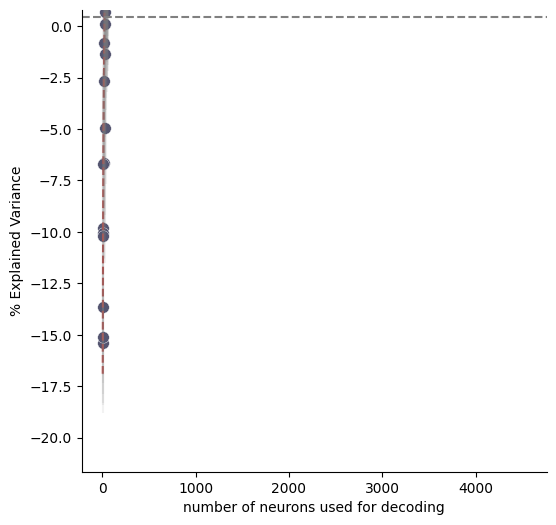

(38.34891735630981, 394.0951440711767)

In [43]:
plt.figure(figsize=(6, 6))
def logistic(x, a, b, c, d):
    return a / (1 + np.exp(-(x - b)/c)) + d
def mix_sigmoid(x, a1, b1, c1, a2, b2, c2, a3, b3, c3, a,b,d):
    sigmoid1 = a1 / (1 + np.exp(-(x - b1)/c1))
    sigmoid2 = a2 / (1 + np.exp(-(x - b2)/c2))
    sigmoid3 = a3 / (1 + np.exp(-(x - b3)/c3))
    return a3*np.log(b*np.abs(x)+d)
    #return a3*np.log(b*np.abs(x)+d)#+a*np.abs(x)**b
    #return sigmoid1+sigmoid2+a3*np.log(b*np.abs(x)+d)
    #return a*sigmoid1*sigmoid2*sigmoid3+d
    #return sigmoid1*sigmoid2+np.log(sigmoid3)+d#np.log(sigmoid1)+d
stride=1
x_data=np.array(list(df['index']))[::stride]
y_data=np.array(list(df['mean'].values))[::stride]
std_data=np.array(list(df['std'].values))[::stride]
plot=True
funct=mix_sigmoid
start= 5
log_scale=False
params, covariance = curve_fit(funct, x_data, y_data,maxfev = 5000000)#, p0=params)
loss = np.sum((y_data - funct(x_data, *params)) ** 2)

if plot:

    x_extrapolated = list(range(start,4537,1))#np.linspace(start, 579, 1000)  # Adjust the range as needed
    y_extrapolated = funct(x_extrapolated, *params)
    sns.scatterplot(x=x_data, y=y_data, s=70, c='#545570', edgecolor='w', linewidth=0.3)
    #plt.scatter(x_data, y_data, label='Original Data')
    plt.plot(x_extrapolated, y_extrapolated, label='Extrapolation', linestyle='--', color='#C53F3B')
    plt.errorbar(x_data,y_data, yerr=std_data, alpha=0.1, c='gray', fmt='None')
    #if log_scale:
    #plt.xscale('log')
    #plt.legend()
    #plt.ylim(None, 60)
    plt.xlabel('% of existing trials taken')
    plt.ylabel('% Explained Variance')
    sns.despine()
    
    plt.xlabel('number of neurons used for decoding')
    plt.axhline(y=0.4578, c='grey', linestyle='dashed')
    #plt.axvline(x=x_extrapolated[index])
    #plt.axhline(y=55.1, c='gray', linestyle='dashed')
    if signature=='C1':
        plt.ylim(None, 1)
    else:
        plt.ylim(None, 0.8)
    #plt.savefig(f'{signature}_extrapolated corr_h7-17.eps')
    #plt.savefig(f'{signature}_extrapolated corr_h7-17.pdf')
    
    plt.show()
y_extrapolated[-1],loss

# increasing neurons

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  

NameError: name 'subsample_trials' is not defined

108